In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
%matplotlib inline
import matplotlib.pyplot as plt
from rtree import index

#import models
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
#from xgboost import XGBRegressor

from sklearn import model_selection
from sklearn.metrics import explained_variance_score
# from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from tabulate import _table_formats, tabulate
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import pygad
import time
import datetime

from sklearn import metrics

In [2]:
# datas = '../MyData.xlsx'
datas = '/Users/pkrok/OneDrive/Python/Giannakopoulos/MyData.xlsx'
# datas = '/Users/panagiotiskrokidas/OneDrive/Python/Giannakopoulos/MyData.xlsx'

In [3]:
pd.set_option("display.max_columns", None)
df=pd.read_excel(datas)
df.head(2)
df['logD'] = np.log10(df['diffusivity'])
# df = df.dropna()
# df[df.gas == 'propylene']['logD'].max()
df[df.gas == 'ethylene']['logD'].count()

68

# Keep only the columns I need

In [4]:
# df2=df[[ 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'gas', 'apertureAtom_e', 'ionicRad']]
df2=df[[ 'type', 'gas', 'MetalNum', 'aperture', 'size - van der Waals (Å)','mass', 'ascentricF', 'logD', 'size - kinetic diameter (Å)', 'ionicRad', 
       'Μ-N_lff', 'Μ-N_kFF', 'MetalCharge',
       'apertureAtom_σ', 'apertureAtom_e', 'linker_length1', 'linker_length2',
       'linker_length3', 'linker_mass1', 'linker_mass2', 'linker_mass3',
       'func1_length', 'func2_length', 'func3_length', 'func1_mass',  
       'func2_mass', 'func3_mass', 'func1_charge', 'func2_charge',
       'func3_charge',]]

In [5]:
df2=df2.rename(columns={'size - van der Waals (Å)':'diameter', 'size - kinetic diameter (Å)':'kdiameter', 'apertureAtom_σ':'σ', 'apertureAtom_e':'e' })

In [6]:
df2 = df2.dropna()
df2=df2.reset_index(drop=True)
# df2
# df2[(df2['logD'] >= -13) & (dfco2['logD'] <= -11.5)]

In [7]:
# df2[(df2['type'] == 'dFm_Be')]

## CO2 dataframe

In [8]:
dfco2=df2[(df2['diameter'] == 3.24)].reset_index()
dfco2=dfco2.drop(columns=['index'])
# dfco2

In [9]:
dfch4=df2[(df2['diameter'] == 3.25)].reset_index()
dfch4=dfch4.drop(columns=['index'])
# dfch4

In [10]:
dfco2[(dfco2['type'] == 'dFm_Be')]

,type,gas,MetalNum,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
65,dFm_Be,CO2,4,3.023,3.24,44.01,0.225,-9.638272,3.3,41,1.759,48367.0,1.2861,0.285,0.255,4.86,4.86,4.86,101.98,101.98,101.98,3.78,3.78,3.78,15.0,15.0,15.0,-0.1873,-0.1873,-0.1873


In [11]:
dfch4[(dfch4['type'] == 'dFm_Be')]

,type,gas,MetalNum,aperture,diameter,mass,ascentricF,logD,kdiameter,ionicRad,Μ-N_lff,Μ-N_kFF,MetalCharge,σ,e,linker_length1,linker_length2,linker_length3,linker_mass1,linker_mass2,linker_mass3,func1_length,func2_length,func3_length,func1_mass,func2_mass,func3_mass,func1_charge,func2_charge,func3_charge
65,dFm_Be,CH4,4,3.023,3.25,16.04,0.011,-14.0,3.8,41,1.759,48367.0,1.2861,0.285,0.255,4.86,4.86,4.86,101.98,101.98,101.98,3.78,3.78,3.78,15.0,15.0,15.0,-0.1873,-0.1873,-0.1873


In [12]:
dfco2 = dfco2.drop([dfco2.index[65]])
dfch4 = dfch4.drop([dfch4.index[65]])

In [13]:
dfco2=dfco2.reset_index()
dfco2=dfco2.drop(columns=['index'])

dfch4=dfch4.reset_index()
dfch4=dfch4.drop(columns=['index'])

In [14]:
# dfch4

## ML models

In [15]:
regr = linear_model.LinearRegression()
tree=DecisionTreeRegressor(max_depth=5,random_state=1)
print(regr)

LinearRegression()


# ga_instance.plot_genes()

## Add more descriptors

## Model with only metal, aperture_e, lengths of linker1&3 and functional1&3

In [16]:
Genes = np.asanyarray(dfco2[[
     'MetalNum',  
     'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length',
                                 ]])

x_co2 = np.asanyarray(dfco2[[
    'MetalNum',  
    'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length',
    'ionicRad',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'σ', 'e', 
    'func1_mass', 'func2_mass', 'func3_mass'
                            ]])


y_co2 = np.array(dfco2[['logD']])

x_ch4 = np.asanyarray(dfch4[[
    'MetalNum',  
    'linker_length1', 'linker_length2', 'linker_length3',
    'func1_length', 'func2_length', 'func3_length',
    'ionicRad',
    'linker_mass1', 'linker_mass2', 'linker_mass3',
    'σ', 'e', 
    'func1_mass', 'func2_mass', 'func3_mass'
                           ]])


y_ch4 = np.array(dfch4[['logD']])

# Libraries

In [17]:
linker_length1 = {3.66:{'linker_mass1':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass1':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass1':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass1':134.906, 'σ':0.34, 'e':1.2552},
                  6.01:{'linker_mass1':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass1':317.8, 'σ':0.367, 'e':1.8731}
                  }

linker_length2 = {3.66:{'linker_mass2':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass2':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass2':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass2':134.906, 'σ':0.34, 'e':1.2552},
                  6.01:{'linker_mass2':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass2':317.8, 'σ':0.367, 'e':1.8731}
                  }
linker_length3 = {3.66:{'linker_mass3':83, 'σ':0.325, 'e':0.7112},
                 4.438:{'linker_mass3':81, 'σ':0.25, 'e':0.0627},
                  4.86:{'linker_mass3':101.98, 'σ':0.285, 'e':0.255},
                   5.7:{'linker_mass3':134.906, 'σ':0.34, 'e':1.2552},
                 5.996:{'linker_mass3':117., 'σ':0.25, 'e':0.0627},
                  6.01:{'linker_mass3':223.8, 'σ':0.4, 'e':0.0627},
                  6.41:{'linker_mass3':317.8, 'σ':0.367, 'e':1.8731}
                  }

func1_length = {2.278:{'func1_mass':1.},
                 3.54:{'func1_mass':35.45},
                  3.78:{'func1_mass':15.},
                   3.85:{'func1_mass':79.9},
                  3.927:{'func1_mass':16.},
                  4.093:{'func1_mass':31.}
                  }

func2_length = {2.278:{'func2_mass':1.},
                 3.54:{'func2_mass':35.45},
                  3.78:{'func2_mass':15.},
                   3.85:{'func2_mass':79.9},
                  3.927:{'func2_mass':16.},
                  4.093:{'func2_mass':31.}
                  }

func3_length = {2.278:{'func3_mass':1.},
                    2.7:{'func3_mass':18.99},
                  3.54:{'func3_mass':35.45},
                  3.78:{'func3_mass':15.},
                   3.85:{'func3_mass':79.9},
                  3.927:{'func3_mass':16.},
                  4.093:{'func3_mass':31.},
                   4.25:{'func3_mass':127.},
                  }
MetalNum = {4:{'ionicRad':41},
           29:{'ionicRad':71},
           12:{'ionicRad':71},
           27:{'ionicRad':72},
           30:{'ionicRad':74},
           25:{'ionicRad':80},
           48:{'ionicRad':92}}

In [225]:
XGBR1 = XGBRegressor(n_estimators=200, max_depth=5, eta=0.2, subsample=0.8, colsample_bytree=0.8)
XGBR2 = XGBRegressor(n_estimators=200, max_depth=5, eta=0.2, subsample=0.8, colsample_bytree=0.8)
# XRegr = XGBR.fit(x_train, y_train)
co2 = XGBR1.fit(x_co2, y_co2)
ch4 = XGBR2.fit(x_ch4, y_ch4)

# predictionch4=ch4.predict([[ 4.0, 4.86, 4.86, 4.86, 3.78, 3.78, 3.78, 41, 101.98, 101.98, 101.98, 0.285, 0.255, 15, 15, 15 ]])
# predictionco2=co2.predict([[ 4.0, 4.86, 4.86, 4.86, 3.78, 3.78, 3.78, 41, 101.98, 101.98, 101.98, 0.285, 0.255, 15, 15, 15 ]])

predictionch4=ch4.predict([[ 27, 4.438, 4.438, 4.438, 3.78, 3.78, 3.78, 72, 81, 81, 81, 0.25, 0.0628, 15, 15, 15 ]])
predictionco2=co2.predict([[ 27, 4.438, 4.438, 4.438, 3.78, 3.78, 3.78, 72, 81, 81, 81, 0.25, 0.0628, 15, 15, 15 ]])

print(predictionco2)
print(predictionch4)

[-9.353413]
[-11.368803]


## Set up my GA

In [19]:
def fitness(solution, solution_idx):
    solution2=np.array([
                  MetalNum[solution[0]]['ionicRad'],
                  linker_length1[solution[1]]['linker_mass1'],
                  linker_length2[solution[2]]['linker_mass2'],
                  linker_length3[solution[3]]['linker_mass3'],
                  linker_length1[solution[1]]['σ'],
                  linker_length1[solution[1]]['e'],
                  func1_length[solution[4]]['func1_mass'],
                  func2_length[solution[5]]['func2_mass'],
                  func3_length[solution[6]]['func3_mass']])
    
    solution3=np.concatenate((solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
    
    floatResult1 = abs(co2.predict([solution3])[0] + 9.6)
    floatResult2 = abs(co2.predict([solution3])[0] - ch4.predict([solution3])[0] - 4.4)
    # return 1.0 - (abs(floatResult - 2) + 10e-10)
    # return 1.0 - ((floatResult1*floatResult2) + 10e-10)
    return 0.8 < 1.0 - ((floatResult1*floatResult2) + 10e-10) <1.3

In [297]:
fitness_function = fitness

num_generations = 15000 # 2000, 12000
num_parents_mating = 14 # 20,  22
 
mutation_probability = [0.4, 0.05] # originally [0.4, 0.01]
mutation_type = "adaptive" # random, swap, inversion, scramble, adaptive

initial_population = Genes[0:68]

# Complete options
# gene_space =  [
#               [4, 12, 25, 27, 29, 30 ],
#               [3.66, 4.438, 4.86, 5.7, 6.01, 6.41],
#               [3.66, 4.438, 4.86, 5.7, 6.01, 6.41],
#               [3.66, 4.438, 4.86, 5.7, 5.996, 6.01, 6.41],
#               [2.278, 3.54, 3.78, 3.85, 3.927, 4.093],
#               [2.278, 3.54, 3.78, 3.85, 3.927, 4.093],
#               [2.278, 2.7, 3.54, 3.78, 3.85, 3.927, 4.093, 4.25],
#               ]

# narrowed down options
gene_space =  [
              [4, 29],
              [4.438, 4.86, 5.7, 6.01, 6.41],
              [4.438, 4.86, 5.7, 6.01, 6.41],
              [4.438, 4.86, 5.7, 6.01, 6.41],
              [2.278, 3.54, 3.78],
              [2.278, 3.54, 3.78],
              [2.278, 2.7, 3.54, 3.78 ]
              ]

parent_selection_type = "tournament" #  "sss", "rws", "tournament", "rank", "random"
K_tournament = 20 #12
keep_parents = 4 # 4, 5

crossover_type = "uniform" # single_point, two_points, uniform, scattered
crossover_probability = 0.7

In [298]:
def on_generation(ga):
    print("Generation", ga.generations_completed)
    print(ga.population)

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       initial_population = initial_population, 
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type, 
                       # mutation_num_genes = mutation_num_genes,
                       gene_space = gene_space,
                       # sol_per_pop = sol_per_pop,
                       # num_genes = num_genes,
                       crossover_probability = crossover_probability,
                       mutation_probability = mutation_probability,
                       K_tournament = K_tournament,
                       allow_duplicate_genes=False,
                       # stop_criteria = "reach_100",
                       # stop_criteria=["reach_127.4", "saturate_160"],
                       save_solutions=True,
                       # on_generation=on_generation,
                       save_best_solutions=True
                      )

C:\Users\pkrok\anaconda3\lib\site-packages\pygad\pygad.py:787: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")
C:\Users\pkrok\anaconda3\lib\site-packages\pygad\pygad.py:795: UserWarning: Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.
  if not self.suppress_warnings: warnings.warn("Use the 'save_solutions' parameter with caution as it may cause memory overflow when either the number of generations, number of genes, or number of solutions in population is large.")


# Single run

In [22]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-04-11 08:35:55


In [23]:
start_time = time.time()
ga_instance.run()
print("--- %s minutes ---" % ((time.time() - start_time)/60))

--- 84.47907915512721 minutes ---


In [24]:
now = datetime.datetime.now()
print ("Current date and time : ")
print (now.strftime("%Y-%m-%d %H:%M:%S"))

Current date and time : 
2022-04-11 10:00:24


In [25]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

solution2=np.array([
                  MetalNum[solution[0]]['ionicRad'],
                  linker_length1[solution[1]]['linker_mass1'],
                  linker_length2[solution[2]]['linker_mass2'],
                  linker_length3[solution[3]]['linker_mass3'],
                  linker_length1[solution[1]]['σ'],
                  linker_length1[solution[1]]['e'],
                  func1_length[solution[4]]['func1_mass'],
                  func2_length[solution[5]]['func2_mass'],
                  func3_length[solution[6]]['func3_mass']])
solution3=np.concatenate((solution,solution2), axis=0, out=None, dtype=None, casting="same_kind")
predictionco2 = co2.predict([solution3])[0]
predictionch4 = ch4.predict([solution3])[0]

print(predictionco2)
print(predictionch4)

Parameters of the best solution : [25.     6.01   4.86   4.438  2.278  3.78   2.7  ]
Fitness value of the best solution = True
-9.607206
-9.392852


In [26]:
solution

array([25.   ,  6.01 ,  4.86 ,  4.438,  2.278,  3.78 ,  2.7  ])

In [27]:
ch4.predict([[72.0, 4.438, 4.438, 4.438, 3.78, 3.78, 3.78, 8.100e+01, 8.100e+01, 8.100e+01, 2.500e-01, 6.270e-02,
       1.500e+01, 1.500e+01, 1.500e+01]])

array([-9.467914], dtype=float32)

In [28]:
dfSol=pd.DataFrame(data = ga_instance.best_solutions)
dfSol.shape

(10001, 7)

In [29]:
dfSol2=dfSol.drop_duplicates(keep='last')
dfSol3 = dfSol2.reset_index()
dfSol3 = dfSol3.drop(columns=['index'])
dfSol3
dfFiveBest = dfSol3
dfFiveBest

,0,1,2,3,4,5,6
0,29.0,5.70,5.70,5.700,3.780,3.780,3.78
1,25.0,5.70,4.86,4.438,2.278,2.278,2.70
2,30.0,6.01,4.86,6.410,2.278,3.780,3.54
3,25.0,5.70,5.70,4.438,3.780,3.540,2.70
4,27.0,6.01,6.01,4.438,3.780,2.278,2.70
...,...,...,...,...,...,...,...
119,25.0,6.41,4.86,4.438,2.278,3.780,2.70
120,25.0,6.01,5.70,4.438,2.278,3.780,2.70
121,25.0,6.01,4.86,4.438,2.278,3.540,2.70
122,25.0,5.70,4.86,4.438,2.278,3.780,2.70


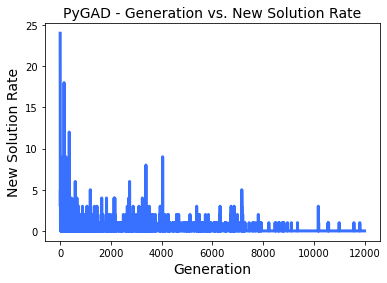

Figure(432x288)


In [296]:
print(ga_instance.plot_new_solution_rate())

In [31]:
# FiveBest = list()

In [49]:
dfSol4 = dfSol3.tail(50)
# dfSol4 = dfSol4.drop(columns=['index'])
solutions = np.asanyarray(dfSol4)
FiveBest.extend(solutions)
FiveBest
dfFiveBest=pd.DataFrame(data = FiveBest)
dfFiveBest

NameError: name 'FiveBest' is not defined

# Loop for GA

In [ ]:
start_time = time.time()

FiveBest = list()

for i in range(8):
    ga_instance.run()
    
    # solution, solution_fitness, solution_idx = ga_instance.best_solution()
    # prediction = XRegr.predict([solution])[0]
    Sol=pd.DataFrame(data = ga_instance.best_solutions)
    Sol2=Sol.drop_duplicates(keep='last')
    Sol3 = Sol2.reset_index()
    # Sol4 = Sol3.tail(20)
    Sol3 = Sol3.drop(columns=['index'])
    # Sol4 = Sol3.tail(20)
    solutions = np.asanyarray(Sol3)
    FiveBest.extend(solutions)

print("--- %s minutes ---" % ((time.time() - start_time)/60))

In [ ]:
dfFiveBest=pd.DataFrame(data = FiveBest)
# dfFiveBest.loc[29]
# dfFiveBest.loc[41]
dfFiveBest

In [ ]:
# TheData = dfFiveBest
# TheData.rename(columns={"0": "metal", "1": "link1", "2": "link2", "3": "link3", "4": "func1", "5": "func2", "6": "func3"})
# TheData.columns = ["metal", "link1", "link2", "link3", "func1", "func2", "func3"]
# TheData
# dfFiveBest[(dfFiveBest[0] == 4.) & (dfFiveBest[1] == 4.86) & (dfFiveBest[2] == 4.86) ]
dfFiveBest[(dfFiveBest[0] == 4.) & (dfFiveBest[2] == 4.86) & (dfFiveBest[5] == 3.78)& (dfFiveBest[6] == 3.78) ]
# dfFiveBest[(dfFiveBest[0] == 4.)  ]
# dfFiveBest[(dfFiveBest[0] == 29.) & (dfFiveBest[1] == 4.438) & (dfFiveBest[2] == 4.438) ]

# RTree

## create dataframe with ratios

In [234]:
dfRatios = pd.DataFrame(columns = ['type', 'MetalNum', 'ratio', 'linker_length1', 'linker_length2', 'linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4'])

In [235]:
k = 0

for i in range(1, len(df2)):
    if df2.loc[i-1, 'type'] == df2.loc[i, 'type'] and df2.loc[i-1, 'gas'] == 'CO2':
        dfRatios.loc[k, 'ratio'] = df2.loc[i-1, 'logD']-df2.loc[i+1, 'logD']
        dfRatios.loc[k, 'type'] = df2.loc[i-1, 'type']
        dfRatios.loc[k, 'logD_co2'] = df2.loc[i-1, 'logD']
        dfRatios.loc[k, 'logD_ch4'] = df2.loc[i+1, 'logD']
        dfRatios.loc[k, ['MetalNum']] =  df2.loc[i-1, ['MetalNum']]
        dfRatios.loc[k, ['linker_length1']] =  df2.loc[i-1, ['linker_length1']]
        dfRatios.loc[k, ['linker_length2']] =  df2.loc[i-1, ['linker_length2']]
        dfRatios.loc[k, ['linker_length3']] =  df2.loc[i-1, ['linker_length3']]
        dfRatios.loc[k, ['func1_length']] =  df2.loc[i-1, ['func1_length']]
        dfRatios.loc[k, ['func2_length']] =  df2.loc[i-1, ['func2_length']]
        dfRatios.loc[k, ['func3_length']] =  df2.loc[i-1, ['func3_length']]
        k=k+1

            
#         else:
#             dfMetal.loc[k , 'metals'] = str('no')
dfRatios.shape

(72, 11)

In [236]:
dfRatios.head(5)

,type,MetalNum,ratio,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4
0,CdIF-1,48,0.187087,4.438,4.438,4.438,3.78,3.78,3.78,-8.39794,-8.585027
1,ZIF-8,30,0.943095,4.438,4.438,4.438,3.78,3.78,3.78,-9.30103,-10.244125
2,ZIF-Cu,29,2.31527,4.438,4.438,4.438,3.78,3.78,3.78,-9.508638,-11.823909
3,ZIF-67,27,2.011899,4.438,4.438,4.438,3.78,3.78,3.78,-9.352617,-11.364516
4,BeIF-1,4,5.591065,4.438,4.438,4.438,3.78,3.78,3.78,-10.505845,-16.09691


In [237]:
df3=dfRatios[[ 'MetalNum',
        'linker_length1', 'linker_length2', 'linker_length3',
        'func1_length' , 'func2_length', 'func3_length']]

In [238]:
def pointToRectangle(pointTuple):
    tmpList = []
    for x in pointTuple:
        tmpList.append(x)
        tmpList.append(x)
    return tuple(tmpList)

In [239]:
p = index.Property()
p.dimension = 7
myidx = index.Index(properties=p, interleaved=False)

In [240]:
myPoints = dict()

for i in range(0, len(df3)):
    myPoints[i] = df3.loc[i]

In [241]:
p.dimension = 7
myidx = index.Index(properties=p, interleaved=False)

for idx in myPoints:
    myidx.insert(idx, pointToRectangle(myPoints[idx]))

## Do Rtree for the best from inverse design

In [242]:
listofBest = list()

for i in range(0, len(dfFiveBest)):
# for i in range(1, len(dfSol3)):
    nearestNeighbour = list(myidx.nearest(pointToRectangle((dfFiveBest.loc[i]))))
    # nearestNeighbour = list(myidx.nearest(pointToRectangle((dfSol3.loc[i]))))
    listofBest.extend(nearestNeighbour)

In [243]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[3]))))
# listofBest

[8]

## Tabulate the best SmartDeZIgn ZIFs from the RTree procedure 

In [244]:
MyBestZIF = pd.DataFrame(columns = ['type', 'MetalNum',
        'linker_length1', 'linker_length2','linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4', 'ratio'])

NotGoodZIF = pd.DataFrame(columns = ['type', 'MetalNum',
        'linker_length1', 'linker_length2','linker_length3',
        'func1_length', 'func2_length','func3_length', 'logD_co2', 'logD_ch4','ratio'])

for i in range(0, len(listofBest)):
    j = listofBest[i]
    if ((3.3 <= dfRatios.loc[j, 'ratio'] <= 4.6) and (-9.9 <= dfRatios.loc[j, 'logD_co2'] <= -8.6)):
    # if 3.9 <= dfRatios.loc[j, 'ratio'] <= 4.4:
    # if df2.loc[i, 'logD'] >= -14 and df2.loc[i, 'logD'] <= -10:
        MyBestZIF.loc[i, ['type']] =  dfRatios.loc[j, ['type']]
        MyBestZIF.loc[i, ['MetalNum']] =  dfRatios.loc[j, ['MetalNum']]
        MyBestZIF.loc[i, ['linker_length1']] =  dfRatios.loc[j, ['linker_length1']]
        MyBestZIF.loc[i, ['linker_length2']] =  dfRatios.loc[j, ['linker_length2']]
        MyBestZIF.loc[i, ['linker_length3']] =  dfRatios.loc[j, ['linker_length3']]
        MyBestZIF.loc[i, ['func1_length']] =  dfRatios.loc[j, ['func1_length']]
        MyBestZIF.loc[i, ['func2_length']] =  dfRatios.loc[j, ['func2_length']]
        MyBestZIF.loc[i, ['func3_length']] =  dfRatios.loc[j, ['func3_length']]
        MyBestZIF.loc[i, ['logD_co2']] =  dfRatios.loc[j, ['logD_co2']]
        MyBestZIF.loc[i, ['logD_ch4']] =  dfRatios.loc[j, ['logD_ch4']]
        MyBestZIF.loc[i, ['ratio']] =  dfRatios.loc[j, ['ratio']]
    else:
        NotGoodZIF.loc[i, ['type']] =  dfRatios.loc[j, ['type']]
        NotGoodZIF.loc[i, ['MetalNum']] =  dfRatios.loc[j, ['MetalNum']]
        NotGoodZIF.loc[i, ['linker_length1']] =  dfRatios.loc[j, ['linker_length1']]
        NotGoodZIF.loc[i, ['linker_length2']] =  dfRatios.loc[j, ['linker_length2']]
        NotGoodZIF.loc[i, ['linker_length3']] =  dfRatios.loc[j, ['linker_length3']]
        NotGoodZIF.loc[i, ['func1_length']] =  dfRatios.loc[j, ['func1_length']]
        NotGoodZIF.loc[i, ['func2_length']] =  dfRatios.loc[j, ['func2_length']]
        NotGoodZIF.loc[i, ['func3_length']] =  dfRatios.loc[j, ['func3_length']]
        NotGoodZIF.loc[i, ['logD_co2']] =  dfRatios.loc[j, ['logD_co2']]
        NotGoodZIF.loc[i, ['logD_ch4']] =  dfRatios.loc[j, ['logD_ch4']]
        NotGoodZIF.loc[i, ['ratio']] =  dfRatios.loc[j, ['ratio']]

In [245]:
MyBestZIF.sort_values(by=['ratio'], ascending=True)

,type,MetalNum,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
237,dBrm_Cu,29,6.01,6.01,6.01,3.78,3.78,3.78,-9.267606,-12.886057,3.61845
530,dBrm_Cu,29,6.01,6.01,6.01,3.78,3.78,3.78,-9.267606,-12.886057,3.61845
165,dBrm_Cu,29,6.01,6.01,6.01,3.78,3.78,3.78,-9.267606,-12.886057,3.61845
514,dBrm_Cu,29,6.01,6.01,6.01,3.78,3.78,3.78,-9.267606,-12.886057,3.61845
270,dBrm_Cu,29,6.01,6.01,6.01,3.78,3.78,3.78,-9.267606,-12.886057,3.61845
...,...,...,...,...,...,...,...,...,...,...,...
588,dClm_Cu,29,5.7,5.7,5.7,3.78,3.78,3.78,-8.69897,-13.080922,4.381952
312,dClm_Cu,29,5.7,5.7,5.7,3.78,3.78,3.78,-8.69897,-13.080922,4.381952
335,dClm_Cu,29,5.7,5.7,5.7,3.78,3.78,3.78,-8.69897,-13.080922,4.381952
253,dClm_Cu,29,5.7,5.7,5.7,3.78,3.78,3.78,-8.69897,-13.080922,4.381952


In [246]:
MyBestZIF.groupby('type').count().sort_values(by=['ratio'], ascending=False)

,MetalNum,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
type,,,,,,,,,,
dFm_Be,139,139,139,139,139,139,139,139,139,139
dClm_Cu,129,129,129,129,129,129,129,129,129,129
dBrm_Cu,35,35,35,35,35,35,35,35,35,35
dIm_Be,29,29,29,29,29,29,29,29,29,29


In [247]:
NotGoodZIF

,type,MetalNum,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length,logD_co2,logD_ch4,ratio
0,ZIF-Cu,29,4.438,4.438,4.438,3.78,3.78,3.78,-9.508638,-11.823909,2.31527
1,Cu-Br-zif-7-8,29,4.438,4.438,5.996,3.78,3.78,3.85,-13.677781,-17.860121,4.18234
3,Br-ZIF-7-8,30,4.438,4.438,5.996,3.78,3.78,3.85,-13.896196,-18.978811,5.082614
4,dBrm_Be,4,6.01,6.01,6.01,3.78,3.78,3.78,-9.251812,-14.30103,5.049218
5,ZIF-7-8,30,4.438,4.438,5.996,3.78,3.78,2.278,-11.801343,-15.30103,3.499687
...,...,...,...,...,...,...,...,...,...,...,...
597,dBrm_Be,4,6.01,6.01,6.01,3.78,3.78,3.78,-9.251812,-14.30103,5.049218
598,dBrm_Be,4,6.01,6.01,6.01,3.78,3.78,3.78,-9.251812,-14.30103,5.049218
599,dBrm_Be,4,6.01,6.01,6.01,3.78,3.78,3.78,-9.251812,-14.30103,5.049218
600,dBrm_Be,4,6.01,6.01,6.01,3.78,3.78,3.78,-9.251812,-14.30103,5.049218


In [248]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[18]))))

[65]

In [249]:
dfRatios.loc[54]

type              Mn-zif-7-8
MetalNum                  25
ratio               5.946922
linker_length1         4.438
linker_length2         4.438
linker_length3         5.996
func1_length            3.78
func2_length            3.78
func3_length           2.278
logD_co2           -11.69897
logD_ch4          -17.645892
Name: 54, dtype: object

In [250]:
MyBestZIF2=MyBestZIF.drop_duplicates().reset_index()

In [251]:
MyBestZIF2 = MyBestZIF2.drop(columns=['index', 'logD_co2', 'logD_ch4','ratio', 'type'])
MyBestZIF2

,MetalNum,linker_length1,linker_length2,linker_length3,func1_length,func2_length,func3_length
0,29,5.7,5.7,5.7,3.78,3.78,3.78
1,4,6.41,6.41,6.41,3.78,3.78,3.78
2,4,4.86,4.86,4.86,3.78,3.78,3.78
3,29,6.01,6.01,6.01,3.78,3.78,3.78


In [252]:
p = index.Property()
p.dimension = 7
myidx2 = index.Index(properties=p, interleaved=False)

In [253]:
myPoints2 = dict()

for i in range(0, len(dfFiveBest)):
    myPoints2[i] = dfFiveBest.loc[i]

In [254]:
p.dimension = 7
myidx2 = index.Index(properties=p, interleaved=False)

for idx in myPoints2:
    myidx2.insert(idx, pointToRectangle(myPoints2[idx]))

In [255]:
listofBest2 = list()

for i in range(0, len(MyBestZIF2)):
# for i in range(1, len(dfSol3)):
    nearestNeighbour2 = list(myidx2.nearest(pointToRectangle((MyBestZIF2.loc[i]))))
    # nearestNeighbour = list(myidx.nearest(pointToRectangle((dfSol3.loc[i]))))
    listofBest2.extend(nearestNeighbour2)

In [256]:
# list(myidx2.nearest(pointToRectangle((MyBestZIF2.loc[0]))))
listofBest2

[517, 548, 278, 428, 180, 301, 15, 315, 517]

In [278]:
dfFiveBest.loc[548]

0    4.00
1    6.41
2    6.41
3    6.01
4    3.54
5    3.54
6    3.78
Name: 548, dtype: float64

In [261]:
list(myidx.nearest(pointToRectangle((dfFiveBest.loc[548]))))

[67]

In [262]:
dfRatios.loc[67]

type                dIm_Be
MetalNum                 4
ratio             4.181844
linker_length1        6.41
linker_length2        6.41
linker_length3        6.41
func1_length          3.78
func2_length          3.78
func3_length          3.78
logD_co2         -9.119186
logD_ch4         -13.30103
Name: 67, dtype: object